#  Предсказание стоимости дома

В проекте нам нужно обучить модель линейной регрессии на данных о [жилье в Калифорнии в 1990 году](https://www.kaggle.com/datasets/camnugent/california-housing-prices) (CC0: Public Domain). 

В колонках датасета содержатся следующие данные:
- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

На основе данных нужно предсказать медианную стоимость дома в жилом массиве — `median_house_value`. 

Оценку качества модели нужно сделать по метрикам RMSE, MAE и R2.

## Цель исследования

Целью исследования являетя разработка модели прогнозирования стоимости жилья с применением распределенных вычислений. 

### Постановка задачи

В данной работе нам надо, используя распределенные вычисления:
- провести анализ данных;
- построить две модели линейной регрессии, предсказывающие стоимость жилья: одну на полном наборе признаков, другую только на числовых признаках;
- сравнить результаты работы по метрикам RMSE, MAE и R2.

### Основные этапы

1. Инициализируем локальную Spark-сессию.
2. Прочитаем содержимое файла `/datasets/housing.csv`.
3. Выведем типы данных колонок датасета, применив методы pySpark.
4. Выполним предобработку данных:
    - Исследуем данные на наличие пропусков и заполним их.
    - Преобразуем колонку с категориальными значениями техникой One hot encoding.
    - Выполним масштабирование числовых значений.
5. Построим две модели линейной регрессии на разных наборах данных:
    - используя все данные из файла;
    - используя только числовые переменные, исключив категориальные.
6. Для построения модели возьмем оценщик LinearRegression из библиотеки MLlib.
7. Сравним результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2. 
8. Сделаем выводы.

### Выводы

Полученные в результате проекта модели объясняют 62-63% изменчивости целевого признака (стоимости жилья), то есть обладают предсказательной способностью.

Модель, построенная на всех признаках показывает результаты чуть лучшие, чем модель только с чиловыми признаками.

Средняя абсолютная ошибка модели составила 50 тыс, исходя из чего мы рекомендуем округлять предсказания модели до 50 тыс.

Для редких значений мы наблюдаем в распределении остатков паттерны, что говорит о смещении модели в диапазоне редких значений. Для улучшения модели мы рекомендуем выполнить анализ выбросов и провести чистку данных.

## Подготовка кода

### Загрузка библиотек

In [2]:
from os.path import exists

In [3]:
import pandas as pd 
import numpy as np

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
RANDOM_SEED = 111973

### Функции

#### explain_model

In [8]:
def explain_model(features_names, model):
    """Отображает коэффициенты регрессии"""
    
    print(f'Свободный член: {model.intercept:.0f}')
    display(pd.DataFrame(
        {'feature': features_names, 
         'coefficient': list(model.coefficients)}
    ).style.format(precision=0))

#### pack_sample_residuals

In [9]:
def pack_sample_residuals(summary, data, independet_feature, fraction):
    """Объединяет остатки со значениями независимой переменной и возвращает сэмпл"""
    
    residuals_id = summary.residuals.withColumn('row_id', F.monotonically_increasing_id())
    feature_id = data.select(independet_feature).withColumn('row_id', F.monotonically_increasing_id())
    packed = feature_id \
             .join(residuals_id, on='row_id') \
             .sample(False, fraction, RANDOM_SEED) \
             .sort(independet_feature)     

    return packed

#### plot_residuals

In [10]:
def plot_residuals(train, test, ax, title, feature):
    """Отображает scatter plot для остатков по независимой переменной"""
    ax.set_title(title.upper())
    ax.set_ylabel('Residuals')
    ax.set_xlabel(feature)

    ax.scatter(train[feature], 
               train.residuals, 
               alpha=.75, 
               marker='.', 
               label='train')
    ax.scatter(test[feature], 
               test.residuals, 
               alpha=.5, 
               marker='x', 
               label='test')
    
    ax.legend(loc = 'upper right')   

## Подготовка данных

### Загрузка данных

Определим путь для загрузки данных: в текущей директории или корневой.

In [11]:
data_path = './datasets/housing.csv'
if not exists(data_path):
    data_path = data_path[1:]
data_path

'./datasets/housing.csv'

Инициализируем локальную Spark-сессию.

In [12]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("California Housing median value prediction") \
                    .getOrCreate()

22/08/04 19:45:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Прочитаем содержимое файла данных.

In [13]:
df_housing = spark.read.load(data_path, 
                             format='csv',
                             sep=',',
                             inferSchema=True,
                             header='true'
                            )
df_housing.count() 

20640

Выведем типы данных колонок датасета.

In [14]:
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



**ВЫВОД**

Мы загрузили датасет в котором 20640 объектов и 10 признаков. 

9 признаков из 10 имеют тип double, один признак строковый. 

Все признаки могут содержать пустые значения.

### Предобработка данных

#### Обзор

Посмотрим на первые 10 строк данных. 

In [15]:
df_housing.limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
longitude,-122.23,-122.22,-122.24,-122.25,-122.25,-122.25,-122.25,-122.25,-122.26,-122.25
latitude,37.88,37.86,37.85,37.85,37.85,37.85,37.84,37.84,37.84,37.84
housing_median_age,41.0,21.0,52.0,52.0,52.0,52.0,52.0,52.0,42.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0,919.0,2535.0,3104.0,2555.0,3549.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0,213.0,489.0,687.0,665.0,707.0
population,322.0,2401.0,496.0,558.0,565.0,413.0,1094.0,1157.0,1206.0,1551.0
households,126.0,1138.0,177.0,219.0,259.0,193.0,514.0,647.0,595.0,714.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462,4.0368,3.6591,3.12,2.0804,3.6912
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0,269700.0,299200.0,241400.0,226700.0,261100.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


Изучим статистики признаков.

In [16]:
df_housing.describe().toPandas().set_index('summary').T

summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0
ocean_proximity,20640,None,None,<1H OCEAN,NEAR OCEAN


Минимальные значения для признаков `housing_median_age`, `total_rooms`, `total_bedrooms`, `population`, `households` похожи на выбросы. В настоящий проект не входит задача анализа выбросов, поэтому отметим ее как рекомендованный шаг по улучшению проекта и продолжим работу с имеющимся датасетом.

Мы видим, что признак `ocean_proximity` является категориальным. Остальные признаки являются числовыми. При этом признаки `longitude` и `longitude` являются географическими координатами жилых массивов.

Целевым признаком в нашей задаче является `median_house_value`.

Сохраним названия целевого, числовых и категориальных признаков.

In [17]:
target = 'median_house_value'
numerical_columns = df_housing.columns[:-1]
numerical_columns.remove(target)
categorical_columns = df_housing.columns[-1:]

In [18]:
numerical_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [19]:
categorical_columns

['ocean_proximity']

In [20]:
target

'median_house_value'

Мы сохранили названия признаков, разделив их на числовые и категориальные, а также выделили целевой признак.

#### Анализ пропусков

Исследуем данные на наличие пропусков и заполним их.

In [21]:
na_count = df_housing \
           .select([F.count(F.when(F.col(c).contains('None') | \
                                   F.col(c).contains('NULL') | \
                                   (F.col(c) == '' ) | \
                                   F.col(c).isNull() | \
                                   F.isnan(c), c 
                                  )).alias(c)
                    for c in df_housing.columns])

na_count.toPandas().T

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


Признак `total_bedrooms` содержит 207 пропусков. Посмотрим на примеры строк с пропусками.

In [22]:
df_housing.filter(df_housing.total_bedrooms.isNull()).toPandas().head(12).T

,0,1,2,3,4,5,6,7,8,9,10,11
longitude,-122.16,-122.17,-122.28,-122.24,-122.1,-122.14,-121.77,-121.95,-121.98,-122.01,-122.08,-119.75
latitude,37.77,37.75,37.78,37.75,37.69,37.67,39.66,38.03,37.96,37.94,37.88,36.71
housing_median_age,47.0,38.0,29.0,45.0,41.0,37.0,20.0,5.0,22.0,23.0,26.0,38.0
total_rooms,1256.0,992.0,5154.0,891.0,746.0,3342.0,3759.0,5526.0,2987.0,3741.0,2947.0,1481.0
total_bedrooms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population,570.0,732.0,3741.0,384.0,387.0,1635.0,1705.0,3207.0,1420.0,1339.0,825.0,1543.0
households,218.0,259.0,1273.0,146.0,161.0,557.0,600.0,1012.0,540.0,499.0,626.0,372.0
median_income,4.375,1.6196,2.5762,4.9489,3.9063,4.7933,4.712,4.0767,3.65,6.7061,2.933,1.4577
median_house_value,161900.0,85100.0,173400.0,247100.0,178400.0,186900.0,158600.0,143100.0,204100.0,322300.0,85000.0,49800.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,INLAND,INLAND,INLAND,NEAR BAY,NEAR BAY,INLAND


Мы видим, что пропуски есть у объектах, имеющих разные значения удаленности от океана. Возможно типы строений для разной удаленности от океана отличаются. Тогда мы можем заполнить пропуски средними значениями для соответвующей категории дальности. 

Проверим эту гипотезу. Посчитаем среднее значение спален по значениям удаленности от океана.

In [23]:
bedrooms_avg = df_housing \
               .select('ocean_proximity', 'total_bedrooms') \
               .groupBy('ocean_proximity') \
               .agg(F.mean('total_bedrooms').alias('total_bedrooms_avg'))

In [24]:
bedrooms_avg.toPandas()

,ocean_proximity,total_bedrooms_avg
0,ISLAND,420.400000
1,NEAR OCEAN,538.615677
2,NEAR BAY,514.182819
3,<1H OCEAN,546.539185
4,INLAND,533.881619


Мы видим, что среднее значение количества спален зависит от дальности жилого массива от океана. Заполним пропуски средними значениями в зависимости от значения `ocean_proximity`.

Присоединим средние значения к основному датасету слева.

In [25]:
df_extended = df_housing.join(bedrooms_avg, ['ocean_proximity'], 'left')

In [26]:
df_extended.select('ocean_proximity', 'total_bedrooms', 'total_bedrooms_avg').show(5)

+---------------+--------------+------------------+
|ocean_proximity|total_bedrooms|total_bedrooms_avg|
+---------------+--------------+------------------+
|       NEAR BAY|         129.0| 514.1828193832599|
|       NEAR BAY|        1106.0| 514.1828193832599|
|       NEAR BAY|         190.0| 514.1828193832599|
|       NEAR BAY|         235.0| 514.1828193832599|
|       NEAR BAY|         280.0| 514.1828193832599|
+---------------+--------------+------------------+
only showing top 5 rows



Теперь заменим пустые значения в столбце total_bedrooms на средние значения, применив трансформацию `coalesce`, которая сохранить непустое значение без изменений, а пустые заменит значениями из переданного столбца.

In [27]:
df_housing = df_extended \
             .withColumn('total_bedrooms', F.coalesce('total_bedrooms', 'total_bedrooms_avg')) \
             .drop('total_bedrooms_avg')

Проверим, что непустые значения сохранились.

In [28]:
df_housing.select('ocean_proximity', 'total_bedrooms').show(5)

+---------------+--------------+
|ocean_proximity|total_bedrooms|
+---------------+--------------+
|       NEAR BAY|         129.0|
|       NEAR BAY|        1106.0|
|       NEAR BAY|         190.0|
|       NEAR BAY|         235.0|
|       NEAR BAY|         280.0|
+---------------+--------------+
only showing top 5 rows



Все в порядке. Проверим, что пропуски заполнены.

In [29]:
na_count = df_housing \
           .select([F.count(F.when(F.col(c).contains('None') | \
                                   F.col(c).contains('NULL') | \
                                   (F.col(c) == '' ) | \
                                   F.col(c).isNull() | \
                                   F.isnan(c), c 
                                  )).alias(c)
                    for c in df_housing.columns])

na_count.toPandas().T

,0
ocean_proximity,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0


Пропусков больше нет. И проверим, что средние значения по категориям дальности не изменились, поскольку мы заполнили пропуски средними же значениями.

In [30]:
bedrooms_avg = df_housing \
               .select('ocean_proximity', 'total_bedrooms') \
               .groupBy('ocean_proximity') \
               .agg(F.mean('total_bedrooms').alias('total_bedrooms_avg'))
bedrooms_avg.toPandas()

,ocean_proximity,total_bedrooms_avg
0,ISLAND,420.400000
1,NEAR OCEAN,538.615677
2,NEAR BAY,514.182819
3,<1H OCEAN,546.539185
4,INLAND,533.881619


Средние значения не изменились. 

**ВЫВОД**

Мы обнаружили 207 пропущенных значений признака `total_bedrooms` и заменили их средними значениями по категориям удаленности от океана.

#### Кодирование категориальных признаков

Преобразуем колонку с категориальными значениями техникой One hot encoding.

Сначала перевем текстовые категории в числовое представление, так как one-hot encoder работает с числовыми индексами категорий.

In [31]:
indexer = StringIndexer(inputCols=categorical_columns, 
                        outputCols=[c+'_idx' for c in categorical_columns]) 
df_housing = indexer.fit(df_housing).transform(df_housing)

In [32]:
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_columns],
                        outputCols=[c+'_ohe' for c in categorical_columns])
df_housing = encoder.fit(df_housing).transform(df_housing)

cols = [c for c in df_housing.columns for i in categorical_columns if (c.startswith(i))]
df_housing.select(cols).show(3) 

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



Сохраним названия признаков, соответвующих их численным индексам.

In [33]:
ocean_proximity_names = [ r['ocean_proximity']  
                       for r in df_housing \
                                .select('ocean_proximity', 'ocean_proximity_idx') \
                                .groupBy('ocean_proximity_idx', 'ocean_proximity') \
                                .count() \
                                .sort('ocean_proximity_idx') \
                                .collect() ]

ocean_proximity_names

['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']

Объединим закодированные признаки в вектор.

In [34]:
categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_columns],
                                        outputCol='categorical_features')
df_housing = categorical_assembler.transform(df_housing) 

**ВЫВОД**

Мы преобразовали признаки с категориальными значениями техникой One hot encoding и сохранили закодированные признаки в вектор.

#### Трансформация числовых признаков

К числовым признакам применим транфсормацию масштабирования, приводящую мат ожидание признака к нулю и дисперисю к 1.

In [35]:
numerical_assembler = VectorAssembler(inputCols=numerical_columns,
                                      outputCol='numerical_features')
df_housing = numerical_assembler.transform(df_housing)

In [36]:
standardScaler = StandardScaler(inputCol='numerical_features',
                                outputCol='numerical_features_scaled')
df_housing = standardScaler.fit(df_housing).transform(df_housing) 

#### Сбор трансформированных признаков

Соберем в один вектор трансформированные категориальные и числовые признаки.

In [37]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features') 
df_housing = final_assembler.transform(df_housing)

Посмотрим на схему итогового датасета.

In [38]:
df_housing.printSchema()

root
 |-- ocean_proximity: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity_idx: double (nullable = false)
 |-- ocean_proximity_ohe: vector (nullable = true)
 |-- categorical_features: vector (nullable = true)
 |-- numerical_features: vector (nullable = true)
 |-- numerical_features_scaled: vector (nullable = true)
 |-- features: vector (nullable = true)



И сохраним названия трансформированных признаков: значения категориального признака кроме последенго .

In [39]:
all_features_names = ocean_proximity_names[:-1] + numerical_columns

all_features_names

['<1H OCEAN',
 'INLAND',
 'NEAR OCEAN',
 'NEAR BAY',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

#### Вывод

На этапе предобработки мы выявили пропуски в признаке total_bedrooms и заполнили их средними значениями по категориям близости к океану.

Мы выполнили кодирование категориальных признаков методом One-hot encoding и сделали масштабирование числовых признаков.

Трансформированные признаки мы собрали в вектора. Для дальнейше работы нам понадобятся:
- `features` для первой модели,
- `numerical_features_scaled` для второй модели.

### Разделение  на обучающую и тестовые выборки

Разделим наш датасет на две части — выборку для обучения и выборку для тестирования качества модели в соотношениее 70:30.

In [40]:
train_data, test_data = df_housing.randomSplit([.7,.3], seed=RANDOM_SEED)
total_count = df_housing.count()
train_count = train_data.count()
test_count = test_data.count()

print(f'Пропорция {train_count/total_count:.1f} : {test_count/total_count:.1f}') 

Пропорция 0.7 : 0.3


In [41]:
train_data.select(target).describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             14491|
|   mean|206347.95983714028|
| stddev|115387.73739756962|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



In [42]:
test_data.select(target).describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|              6149|
|   mean| 208052.6549032363|
| stddev|115414.72531459454|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



Мы видим, что статистики обучающей и тестовой выборок схожи, значит разделение выполнено корректно.

### Вывод

Мы проанализировали данные, исправили ошибки, закодировали строковые категориальные значения, привели числовые признаки к одному масштабу и подготовили обучающую и тестовую выборки.

## Обучение моделей

Для построения модели возьмем оценщик LinearRegression из библиотеки MLlib. 

Построим две модели линейной регрессии на разных наборах данных: полном наборе и только на числовых признаках.

### Полный набор данных

Создадим оценщик для всех данных, обучем его на обучающем датасете, и сохраним трансформер обученной модели.

In [43]:
lr_all = LinearRegression(labelCol=target, 
                          featuresCol='features',
                          maxIter=10, 
                          regParam=0.3)
model_all = lr_all.fit(train_data)

22/08/04 19:46:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/08/04 19:46:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/08/04 19:46:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/08/04 19:46:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Теперь мы можем применить трансформер для оценки качества модели и предсказания на тестовой выборке. Сохраним результаты оценки и новый датасет с предсказаниями для анализа.

In [44]:
evaluation_all = model_all.evaluate(test_data)

In [45]:
predictions_all = model_all.transform(test_data)

predictedLabes_all = predictions_all.select('features', target, 'prediction')
predictedLabes_all.show(5) 

+--------------------+------------------+------------------+
|            features|median_house_value|        prediction|
+--------------------+------------------+------------------+
|[1.0,0.0,0.0,0.0,...|           92500.0|165973.57299855934|
|[1.0,0.0,0.0,0.0,...|           55000.0|213797.76812711987|
|[1.0,0.0,0.0,0.0,...|           72300.0|153787.03982375166|
|[1.0,0.0,0.0,0.0,...|           57500.0|155369.46075806045|
|[1.0,0.0,0.0,0.0,...|          119900.0| 206286.2321400924|
+--------------------+------------------+------------------+
only showing top 5 rows



Посмотрим на параметры линейной регресии, подобранные моделью при обучении.

In [46]:
explain_model(all_features_names, model_all)

Свободный член: -2030560


,feature,coefficient
0,<1H OCEAN,-155690
1,INLAND,-194823
2,NEAR OCEAN,-151279
3,NEAR BAY,-159976
4,longitude,-51875
5,latitude,-52818
6,housing_median_age,13632
7,total_rooms,-10429
8,total_bedrooms,28865
9,population,-47462


Мы видим, что наибольшие абослютные значения у категориального признака; возраст дома, количество спален, количестов домохозяйств и средний доход увеличивают стоимость, а остальные признаки уменьшают. 

### Только числовые признаки

Выполним аналогичные действия для числовых признаков.

In [47]:
lr_num = LinearRegression(labelCol=target, 
                          featuresCol='numerical_features_scaled', 
                          maxIter=10,                           
                          regParam=0.3)
model_num = lr_num.fit(train_data)

In [48]:
evaluation_num = model_num.evaluate(test_data)

In [49]:
predictions_num = model_num.transform(test_data)

predictedLabes_num = predictions_num.select('numerical_features_scaled', target, 'prediction')
predictedLabes_num.show(5) 

+-------------------------+------------------+------------------+
|numerical_features_scaled|median_house_value|        prediction|
+-------------------------+------------------+------------------+
|     [-61.960586170793...|           92500.0|140238.96991453366|
|     [-61.940621425772...|           55000.0|192271.63086276362|
|     [-61.940621425772...|           72300.0|128978.84227293357|
|     [-61.940621425772...|           57500.0|131736.41400379408|
|     [-61.900691935732...|          119900.0| 177120.9397273166|
+-------------------------+------------------+------------------+
only showing top 5 rows



И посмотрим на коэффициенты получившейся регрессии.

In [50]:
explain_model(numerical_columns, model_num)

Свободный член: -3496029


,feature,coefficient
0,longitude,-83668
1,latitude,-89155
2,housing_median_age,14625
3,total_rooms,-14655
4,total_bedrooms,33065
5,population,-48095
6,households,33389
7,median_income,76281


Мы видим, что характер коэффициентов не изменился: возраст дома, количество спален, количестов домохозяйств и средний доход увеличивают стоимость, а остальные признаки уменьшают. И, поскольку мы убрали категориальный признак удаленности от океана, выросло значение признаков `longitude` и `latitude`.

## Анализ результатов

Для анализа результатов рассчитаем требуемые условиями задачи метрики для обучающей выборки (трансформеры model_all и model_num) и тестовой выборки (predictions_all, predictions_num).

Чтобы оценить смещение модели, построим графики отклонений для независимой переменной `median_income` как одной из наиболее значимых в обоих моделях регрессии.

### Расчет метрик

Сравним результаты работы двух моделей на тестовой выборке по метрикам MAE, RMSE и R2. 

In [51]:
result = None
for summary, name in zip([model_all.summary, evaluation_all, model_num.summary, evaluation_num], 
                         ['все train', 'все test', 'колич train', 'колич test']):
    column  = pd.Series([summary.meanAbsoluteError,
                         summary.rootMeanSquaredError,
                         summary.r2],
                        name=name,
                        index=['MAE', 'RMSE', 'R2'])
    if result is not None:
        result = pd.concat([result, column], axis=1)
    else:
        result = column

In [52]:
result.style.format(precision=2)

,все train,все test,колич train,колич test
MAE,49639.33,49987.68,50715.55,51017.21
RMSE,68185.93,69990.34,69136.16,70929.75
R2,0.65,0.63,0.64,0.62


**ВЫВОД**

Мы видим, что результаты двух моделей близки. Модель со всеми признаками работает немного лучше модели с только числовыми признаками. Результаты на тестовой выборке немного хуже результатов на обучающей. 

Наша модель со всем признаками объясняет 63% изменчивости, а модель только с числовыми признаками — 62% изменчивости зависимой величины. То есть модели обладают предсказательными способностями.

Отметим, что значения RMSE выше MAE. 

RMSE чувствительная к изменению частоты ошибок. Если для каждого предсказания у нас была бы одинаковая ошибка, то MAE и RMSE были одинаковы. Но если для предсказаний ошибки разные, то MAE и RMSE будут отличаться, что мы и наблюдаем. При этом [MAE больше реагирует на изменение размера ошибки, а RMSE на частоту изменений размера ошибки](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d).

В нашем случае мы видим, что среди ошибок есть редкие выбросы. Такой результат может быть следствием пропущенного этапа анализа выбросов в данных и их чистки перед обучением. 

### Оценка состоятельности модели

Для оценки состоятельности модели добавим к обучающей и тестовой выборке среднее значение стоимости жилья в обучающей выборке. Сравним качество полученных моделей с моделью, предсказывающей среднее значение.

In [53]:
mean = train_data.groupBy().avg(target).take(1)[0][0]
train_data = train_data.withColumn('average_price', F.lit(mean))
test_data = test_data.withColumn('average_price', F.lit(mean))
train_data.select(target, 'average_price').show(5)

+------------------+------------------+
|median_house_value|     average_price|
+------------------+------------------+
|           75100.0|206347.95983714028|
|           94800.0|206347.95983714028|
|           74100.0|206347.95983714028|
|           70500.0|206347.95983714028|
|           97300.0|206347.95983714028|
+------------------+------------------+
only showing top 5 rows



In [54]:
test_data.select(target, 'average_price').show(5)

+------------------+------------------+
|median_house_value|     average_price|
+------------------+------------------+
|           92500.0|206347.95983714028|
|           55000.0|206347.95983714028|
|           72300.0|206347.95983714028|
|           57500.0|206347.95983714028|
|          119900.0|206347.95983714028|
+------------------+------------------+
only showing top 5 rows



In [55]:
dummy_train_mae = RegressionEvaluator(labelCol=target, 
                                      predictionCol='average_price', 
                                      metricName='mae') \
                  .evaluate(train_data)

In [56]:
dummy_test_mae = RegressionEvaluator(labelCol=target, 
                                     predictionCol='average_price', 
                                     metricName='mae') \
                 .evaluate(test_data)

In [57]:
print(f'Dummy MAE on train:\t{dummy_train_mae:.0f}')
print(f'Dummy MAE on test:\t{dummy_test_mae:.0f}')

Dummy MAE on train:	90933
Dummy MAE on test:	91412


Мы видим, что MAE наших моделей в два раза меньше модели, предсказывающей среднее значение. Это позовляет утверждать, что модель полезна и может применяться для прогнозирования стоимости. 

Учитывая, что  MAE модели 50 тыс, а значения стоимости лежат в диапазоне 15-500 тыс, мы рекомендуем округлять предсказания до 50 тыс. 

### Оценка смещения

Оценим визуально смещение в предсказаниях модели. Построим график остатков для значений независмой переменной `median_income` для сэмплов из 1000 значений.

Для этого объединим значения остатков со значениями независимой переменной по порядку и возьмем сэмпл требуемой величины. Выполним эту операцию для результатов обучения и тестирования каждой модели.

In [58]:
train_all = pack_sample_residuals(model_all.summary, 
                                  train_data, 'median_income', 
                                  1000/train_count).toPandas()

In [59]:
test_all = pack_sample_residuals(model_all.summary, 
                                 test_data, 'median_income', 
                                 1000/test_count).toPandas()

In [60]:
train_num = pack_sample_residuals(model_num.summary, 
                                  train_data, 'median_income', 
                                  1000/train_count).toPandas()

In [61]:
test_num = pack_sample_residuals(model_num.summary, 
                                  test_data, 'median_income', 
                                  1000/test_count).toPandas()

Теперь построим графики.

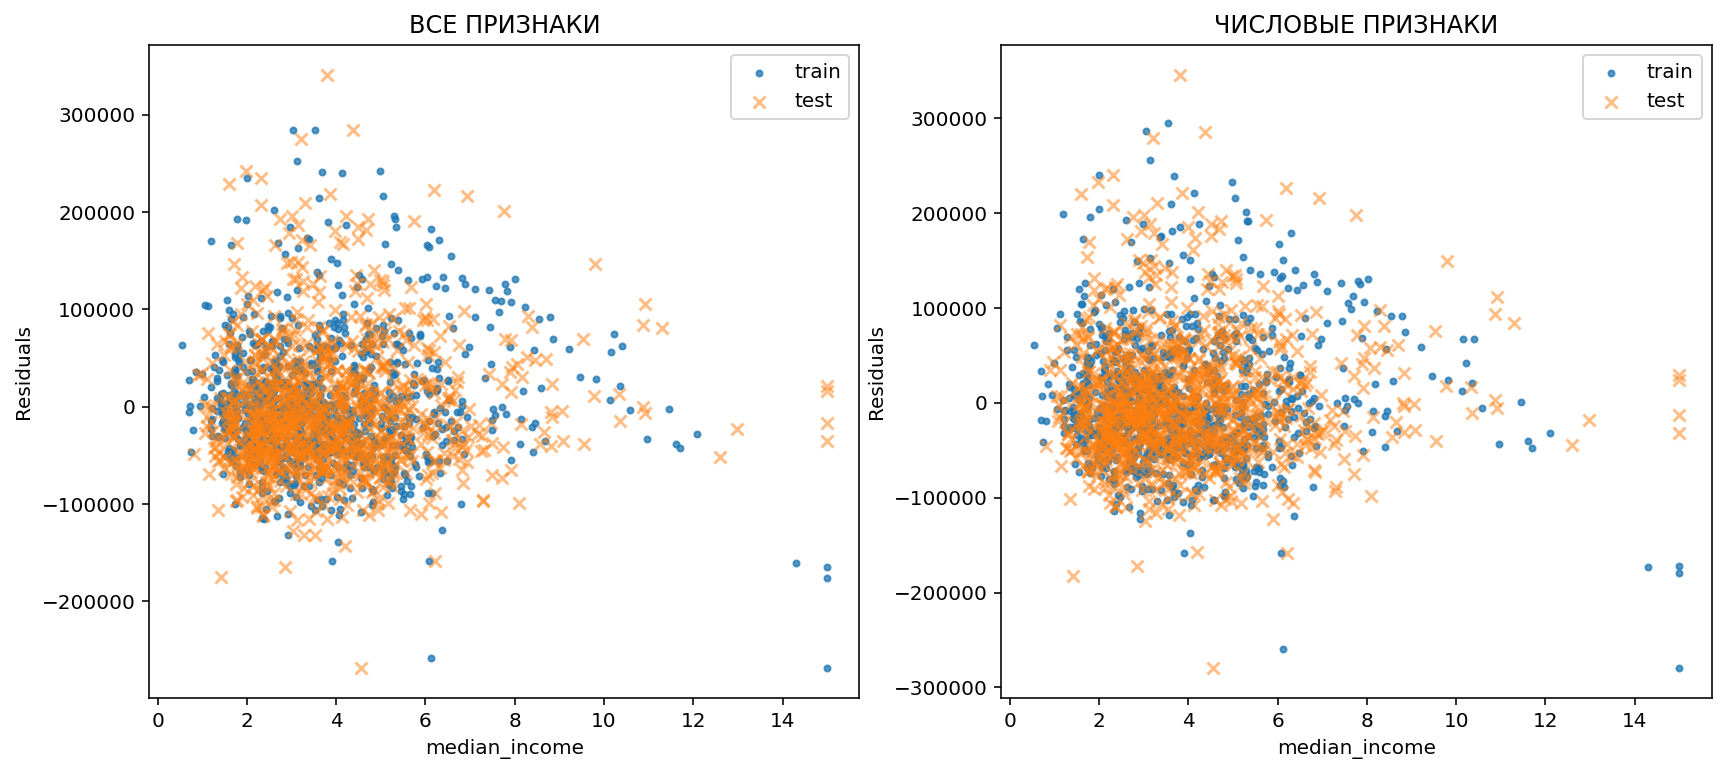

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_residuals(train_all, test_all, axes[0], 'Все признаки', 'median_income')
plot_residuals(train_num, test_num, axes[1], 'Числовые признаки', 'median_income')
plt.show()

Графики подтверждают вывод о наличии редких выбросов в остатках, сделанный на основании того, что RMSE больше MAE.

В дипазоне значений median_income от 6 и выше мы наблюдаем паттерн в остатках — убывающая прямая от 200 до -200 тыс. Это говорит о том, что у модели есть смещение в этом диапазоне значений независимой переменной. 

При этом большинство точек находится в диапазоне median_income от 1 до 6, где паттерна в распределении остатков мы не наблюдаем.


## Выводы

В настоящем проекты мы применили распределенные вычисления для анализа, предобработки данных и построения модели линейной регрессии для предсказания стоимости жилья.

На этапе предобработки данных мы обнаружили пропуски в признаке `total_bedrooms` и заполнили пропуски средними значениями, рассчитанными для каждого из значений категориального признака `ocean_proximity`.

Мы применили кодирование методом ohe-hot encoding для категориального признака и масштабирование для числовых признаков. 

Далее мы обучили и протестировали две модели: первая на всех признаках и вторая только на числовых.

Полученные модели объясняют 62-63% изменчивости целевого признака (стоимости жилья), то есть обладают предсказательной способностью. 

Модель, построенная на всех признаках показывает результаты чуть лучшие, чем модель только с чиловыми признаками.

В границы настоящего проекта не входил анализ данных на выбросы и их чистка, что сказалось на результатах обучения модели: в предсказаниях мы видим редкие большие ошибки, дающие RMSE 70 тыс.

Средняя абсолютная ошибка модели составила 50 тыс, исходя из чего мы рекомендуем округлять предсказания модели до 50 тыс.

Для редких значений мы наблюдаем в распределении остатков паттерны, что говорит о смещении модели в диапазоне редких значений. Для улучшения модели мы рекомендуем выполнить анализ выбросов и провести чистку данных.